<a href="https://colab.research.google.com/github/hectorcamachoz/Proyecto_2_Inteligenci_Artificial/blob/main/Proyecto2_594557.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto 2. Inteligencia Artificial

En este proyecto se utilizara la base de datos proporcionada por Kaggle especificamente de la competencia "Spaceship Titanic". El objetivo de este proyecto es realizar algunos de los multiples modelos vistos en clase, como LDA, QDA, Regresion Logistica, Árboles de decisión, bagging, random forests, boosting, y seleccionar cual es el mejor el resultado que se obtenga se mandara a la competencia de Kaggle. Nuestra variable de salida sera la variable Transported que tiene como valores True o False.


La descripcion de cada variable se encuentra en el archivo: 'descripcion_vars_kaggle.txt'


**1.** Primero se importara la base de datos train.csv, sera analizada con diferentes funciones para observar si existen huecos, si se deben realizar variables dummy, y de esta manera realizar una limpia.


In [422]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

df = pd.concat([df_train, df_test])
df.head()
df.info()

print('\nHuecos: ')
print(df.isnull().sum())

print('\nBalanceo de Clases en Train.csv:\n',df_train['Transported'].value_counts())

<class 'pandas.core.frame.DataFrame'>
Index: 12970 entries, 0 to 4276
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   12970 non-null  object 
 1   HomePlanet    12682 non-null  object 
 2   CryoSleep     12660 non-null  object 
 3   Cabin         12671 non-null  object 
 4   Destination   12696 non-null  object 
 5   Age           12700 non-null  float64
 6   VIP           12674 non-null  object 
 7   RoomService   12707 non-null  float64
 8   FoodCourt     12681 non-null  float64
 9   ShoppingMall  12664 non-null  float64
 10  Spa           12686 non-null  float64
 11  VRDeck        12702 non-null  float64
 12  Name          12676 non-null  object 
 13  Transported   8693 non-null   object 
dtypes: float64(6), object(8)
memory usage: 1.5+ MB

Huecos: 
PassengerId        0
HomePlanet       288
CryoSleep        310
Cabin            299
Destination      274
Age              270
VIP              296


Se puede observar que la muchas variables son de tipo object, por lo tanto para primero utilizar regresion logistica, es necesario convertir estas variables a variables dummy.

Primero se eliminaran las variables PassengerId y Name, ya que esas no nos serviran para el entrenamiento del modelo.

In [423]:
df = df.drop(['PassengerId', 'Name'], axis=1)

En la tabla de huecos en el primer apartado, se puede observar que existen mulitples en variables tipo float, por lo tanto, los huecos en esas variables se sustituiran por 0.

In [424]:
df[['VIP', 'CryoSleep', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']] = df[['VIP', 'CryoSleep', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].fillna(value=0)
df.isnull().sum().sort_values(ascending=False)

,0
Transported,4277
Cabin,299
HomePlanet,288
Destination,274
Age,270
RoomService,263
CryoSleep,0
VIP,0
FoodCourt,0
ShoppingMall,0


Para evitar problemas con la regresion logistica, necesitamos convertir los datos de object, y los booleanos a variables numericas.

In [425]:

df['CryoSleep'] = df['CryoSleep'].astype(int)
df['VIP'] = df['VIP'].astype(int)

df.head(5)

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,Europa,0,B/0/P,TRAPPIST-1e,39.0,0,0.0,0.0,0.0,0.0,0.0,False
1,Earth,0,F/0/S,TRAPPIST-1e,24.0,0,109.0,9.0,25.0,549.0,44.0,True
2,Europa,0,A/0/S,TRAPPIST-1e,58.0,1,43.0,3576.0,0.0,6715.0,49.0,False
3,Europa,0,A/0/S,TRAPPIST-1e,33.0,0,0.0,1283.0,371.0,3329.0,193.0,False
4,Earth,0,F/1/S,TRAPPIST-1e,16.0,0,303.0,70.0,151.0,565.0,2.0,True


La variable Cabin, esta compuesta por tres datos, Deck/Cabin number/Side. Para facilitar esta variable se dividira en tres columnas. Este codigo es una combinacion de algunos competidores uno llamado Gusthema y otro llamado Eunice Cleofas

In [426]:

df[["Deck", "Cabin_num", "Side"]] = df["Cabin"].str.split("/", expand=True)
df = df.drop(['Cabin'], axis = 1)
df[['Cabin_num']] = df[['Cabin_num']].fillna(df['Cabin_num'].mode().iloc[0])
df[['Deck']] = df[['Deck']].fillna(df['Deck'].mode().iloc[0])
df[['Side']] = df[['Side']].fillna(df['Side'].mode().iloc[0])
df['Age'] = df['Age'].fillna(df['Age'].median())
df['RoomService'] = df['RoomService'].fillna(df['RoomService'].median())

df['HomePlanet'] = df['HomePlanet'].fillna(df['HomePlanet'].mode().iloc[0])
df['Destination'] = df['Destination'].fillna(df['Destination'].mode().iloc[0])


df.head(5)

df.isnull().sum().sort_values(ascending=False)

,0
Transported,4277
HomePlanet,0
Destination,0
Age,0
VIP,0
CryoSleep,0
RoomService,0
FoodCourt,0
Spa,0
ShoppingMall,0


Se convertiran las variables HomePlanet, Destination, Size a variables de 0 y 1,.

In [427]:
df = pd.get_dummies(df,columns= ['HomePlanet', 'Destination','Side'], drop_first = False)
df = pd.get_dummies(df, columns = ['Deck'], drop_first = False)
df.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Cabin_num,...,Side_P,Side_S,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T
0,0,39.0,0,0.0,0.0,0.0,0.0,0.0,False,0,...,True,False,False,True,False,False,False,False,False,False
1,0,24.0,0,109.0,9.0,25.0,549.0,44.0,True,0,...,False,True,False,False,False,False,False,True,False,False
2,0,58.0,1,43.0,3576.0,0.0,6715.0,49.0,False,0,...,False,True,True,False,False,False,False,False,False,False
3,0,33.0,0,0.0,1283.0,371.0,3329.0,193.0,False,0,...,False,True,True,False,False,False,False,False,False,False
4,0,16.0,0,303.0,70.0,151.0,565.0,2.0,True,1,...,False,True,False,False,False,False,False,True,False,False


Para evitar tener muchas columnas, sumare los gastos de cada pasajero, estos los pondre en una columna llamada **Expenses**, y eliminare las otras columnas.

In [428]:
df['Expenses'] = df['RoomService'] + df['FoodCourt'] + df['ShoppingMall'] + df['Spa'] + df['VRDeck']
df = df.drop(['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'], axis = 1)
df.head()

,CryoSleep,Age,VIP,Transported,Cabin_num,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,...,Side_S,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Expenses
0,0,39.0,0,False,0,False,True,False,False,False,...,False,False,True,False,False,False,False,False,False,0.0
1,0,24.0,0,True,0,True,False,False,False,False,...,True,False,False,False,False,False,True,False,False,736.0
2,0,58.0,1,False,0,False,True,False,False,False,...,True,True,False,False,False,False,False,False,False,10383.0
3,0,33.0,0,False,0,False,True,False,False,False,...,True,True,False,False,False,False,False,False,False,5176.0
4,0,16.0,0,True,1,True,False,False,False,False,...,True,False,False,False,False,False,True,False,False,1091.0


In [429]:
df['HomePlanet_Europa'] = df['HomePlanet_Europa'].astype(int)
df['HomePlanet_Mars'] = df['HomePlanet_Mars'].astype(int)
df['HomePlanet_Earth'] = df['HomePlanet_Earth'].astype(int)
df['Destination_TRAPPIST-1e'] = df['Destination_TRAPPIST-1e'].astype(int)
df['Destination_PSO J318.5-22'] = df['Destination_PSO J318.5-22'].astype(int)
df['Destination_55 Cancri e'] = df['Destination_55 Cancri e'].astype(int)
df['Side_S'] = df['Side_S'].astype(int)
df['Side_P'] = df['Side_P'].astype(int)
df['Deck_F'] = df['Deck_F'].astype(int)
df['Deck_G'] = df['Deck_G'].astype(int)
df['Deck_E'] = df['Deck_E'].astype(int)
df['Deck_B'] = df['Deck_B'].astype(int)
df['Deck_D'] = df['Deck_D'].astype(int)
df['Deck_C'] = df['Deck_C'].astype(int)
df['Deck_A'] = df['Deck_A'].astype(int)
df['Deck_T'] = df['Deck_T'].astype(int)
df.head()

,CryoSleep,Age,VIP,Transported,Cabin_num,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,...,Side_S,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Expenses
0,0,39.0,0,False,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0.0
1,0,24.0,0,True,0,1,0,0,0,0,...,1,0,0,0,0,0,1,0,0,736.0
2,0,58.0,1,False,0,0,1,0,0,0,...,1,1,0,0,0,0,0,0,0,10383.0
3,0,33.0,0,False,0,0,1,0,0,0,...,1,1,0,0,0,0,0,0,0,5176.0
4,0,16.0,0,True,1,1,0,0,0,0,...,1,0,0,0,0,0,1,0,0,1091.0


In [430]:
print(df.isnull().sum())

CryoSleep                       0
Age                             0
VIP                             0
Transported                  4277
Cabin_num                       0
HomePlanet_Earth                0
HomePlanet_Europa               0
HomePlanet_Mars                 0
Destination_55 Cancri e         0
Destination_PSO J318.5-22       0
Destination_TRAPPIST-1e         0
Side_P                          0
Side_S                          0
Deck_A                          0
Deck_B                          0
Deck_C                          0
Deck_D                          0
Deck_E                          0
Deck_F                          0
Deck_G                          0
Deck_T                          0
Expenses                        0
dtype: int64


Por ultimo escalaremos las variables Age, RoomService, FoodCourt, ShoppingMall, Spa, VRDeck, para tenerlas en valores mas pequeños y que sea mas facil para nuestro modelo.

In [431]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
cols_to_scale = ['Age','Expenses']
df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])
df.head()

,CryoSleep,Age,VIP,Transported,Cabin_num,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,...,Side_S,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Expenses
0,0,0.720932,0,False,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,-0.510541
1,0,-0.332557,0,True,0,1,0,0,0,0,...,1,0,0,0,0,0,1,0,0,-0.248363
2,0,2.055350,1,False,0,0,1,0,0,0,...,1,1,0,0,0,0,0,0,0,3.188082
3,0,0.299536,0,False,0,0,1,0,0,0,...,1,1,0,0,0,0,0,0,0,1.333249
4,0,-0.894417,0,True,1,1,0,0,0,0,...,1,0,0,0,0,0,1,0,0,-0.121906


Por ultimo, se volveran a separar las bases de datos en train y test. Y la variable Transported que esta en la base de datos de train sera convertida a un valor binario.

In [432]:
df_train_processed = df.iloc[:len(df_train)]
df_test_processed = df.iloc[len(df_train):]

df_train_processed['Transported'] = df_train_processed['Transported'].astype(int)
df_test_processed = df_test_processed.drop(['Transported'], axis = 1)
df_test_processed['PassengerId'] = df_test['PassengerId']

print('Base de datos Train: ')
print('\n',df_train_processed.head())

print('\nBase de datos Test: ')
print('\n',df_test_processed.head())

#df_test_processed, se usara para el test final, para asi evitar a toda costa una fuga de datos.


x = df_train_processed.drop(['Transported'], axis = 1)
y = df_train_processed['Transported']
norm = StandardScaler()
x = norm.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=42)


Base de datos Train: 

    CryoSleep       Age  VIP  Transported Cabin_num  HomePlanet_Earth  \
0          0  0.720932    0            0         0                 0   
1          0 -0.332557    0            1         0                 1   
2          0  2.055350    1            0         0                 0   
3          0  0.299536    0            0         0                 0   
4          0 -0.894417    0            1         1                 1   

   HomePlanet_Europa  HomePlanet_Mars  Destination_55 Cancri e  \
0                  1                0                        0   
1                  0                0                        0   
2                  1                0                        0   
3                  1                0                        0   
4                  0                0                        0   

   Destination_PSO J318.5-22  ...  Side_S  Deck_A  Deck_B  Deck_C  Deck_D  \
0                          0  ...       0       0       1       0    

<ipython-input-432-1c2b2048637b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_processed['Transported'] = df_train_processed['Transported'].astype(int)


Finalmente, se ha concluido el preprocesamiento, limpieza, y ajuste de la base de datos.

# Regresion Logistica

A continuacion se generara un modelo de regresion logistica con validacion cruzada por el metodo de K-Folds, y se desplegaran las metricas para evaluar la calidad de este modelo.


Accuracy:  0.7176521249461725
Precision:  0.7742382271468145
Sensitivity:  0.6381278538812786
Specificity:  0.8111239860950173
F1-Score:  0.6996245306633292
Matriz de confusion: 



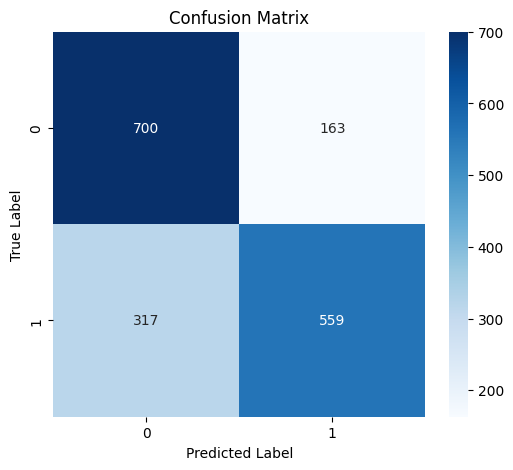

In [433]:
import statsmodels.api as sm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt

md_logReg = LogisticRegression()
md_logReg.fit(x_train, y_train)
kf = KFold(n_splits=5, shuffle=True, random_state=42)


y_pred_logReg = md_logReg.predict(x_test)
logReg_accuracy = cross_val_score(md_logReg, x_test, y_test, cv=kf, scoring='accuracy')
cm = confusion_matrix(y_test, y_pred_logReg)
labels = ['True Neg','False Pos','False Neg','True Pos']

print('Accuracy: ', logReg_accuracy.mean())
print('Precision: ', precision_score(y_test, y_pred_logReg))
print('Sensitivity: ', recall_score(y_test, y_pred_logReg))
print('Specificity: ', recall_score(y_test, y_pred_logReg, pos_label=0))
print('F1-Score: ', f1_score(y_test, y_pred_logReg))
print('Matriz de confusion: \n')
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()



# LDA

A continuacion se generara un modelo LDA con k-Fold cross-validation.

Accuracy:  0.7239723077942297
Precision:  0.8002980625931445
Sensitivity:  0.613013698630137
Specificity:  0.8447276940903824
F1-Score:  0.6942469295410472
Matriz de confusion: 



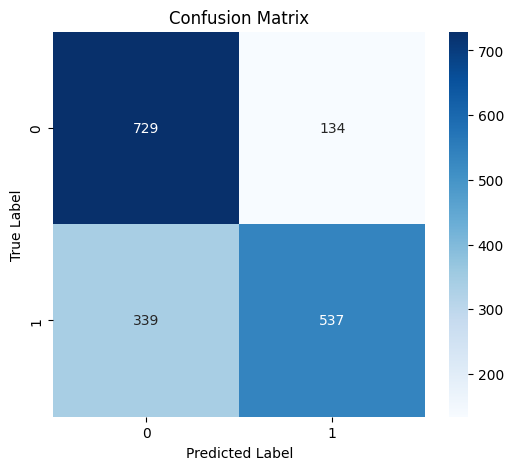

In [434]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

md_lda = LinearDiscriminantAnalysis()
kf = KFold(n_splits=5, shuffle=True, random_state=42)
md_lda.fit(x_train, y_train)
y_pred_lda = md_lda.predict(x_test)
lda_accuracy = cross_val_score(md_lda, x_test, y_test, cv=kf, scoring='accuracy')
cm = confusion_matrix(y_test, y_pred_lda)
labels = ['True Neg','False Pos','False Neg','True Pos']

print('Accuracy: ', lda_accuracy.mean())
print('Precision: ', precision_score(y_test, y_pred_lda))
print('Sensitivity: ', recall_score(y_test, y_pred_lda))
print('Specificity: ', recall_score(y_test, y_pred_lda, pos_label=0))
print('F1-Score: ', f1_score(y_test, y_pred_lda))
print('Matriz de confusion: \n')
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Árbol de Decisión

Accuracy:  0.6756848520984465
Precision:  0.6909920182440137
Sensitivity:  0.6917808219178082
Specificity:  0.6859791425260718
F1-Score:  0.6913861950941244
Matriz de confusion: 



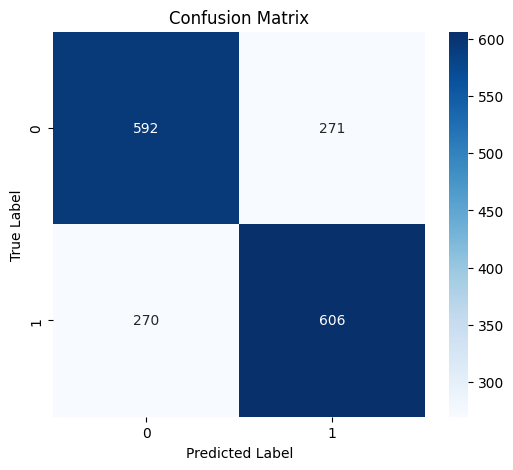

In [435]:
from sklearn.tree import DecisionTreeClassifier

md_tree = DecisionTreeClassifier()
md_tree.fit(x_train, y_train)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
y_pred_tree = md_tree.predict(x_test)
tree_accuracy = cross_val_score(md_tree, x_test, y_test, cv=kf, scoring='accuracy')
cm = confusion_matrix(y_test, y_pred_tree)

print('Accuracy: ', tree_accuracy.mean())
print('Precision: ', precision_score(y_test, y_pred_tree))
print('Sensitivity: ', recall_score(y_test, y_pred_tree))
print('Specificity: ', recall_score(y_test, y_pred_tree, pos_label=0))
print('F1-Score: ', f1_score(y_test, y_pred_tree))
print('Matriz de confusion: \n')
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
#

# Random Forest

Accuracy:  0.7360644605651065
Precision:  0.8162983425414365
Sensitivity:  0.6746575342465754
Specificity:  0.8458864426419467
F1-Score:  0.73875
Matriz de confusion: 



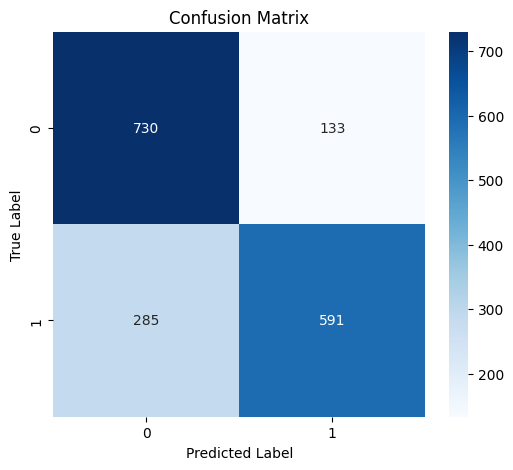

In [436]:
from sklearn.ensemble import RandomForestClassifier as RFC

md_rf = RFC(n_estimators=150, min_samples_split=6, max_depth=15 ,random_state=42)
md_rf.fit(x_train, y_train)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
y_pred_rf = md_rf.predict(x_test)
rf_accuracy = cross_val_score(md_rf, x_test, y_test, cv=kf, scoring='accuracy')
cm = confusion_matrix(y_test, y_pred_rf)

print('Accuracy: ', rf_accuracy.mean())
print('Precision: ', precision_score(y_test, y_pred_rf))
print('Sensitivity: ', recall_score(y_test, y_pred_rf))
print('Specificity: ', recall_score(y_test, y_pred_rf, pos_label=0))
print('F1-Score: ', f1_score(y_test, y_pred_rf))
print('Matriz de confusion: \n')
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# Boosting

Accuracy:  0.7308738282155751
Precision:  0.7830188679245284
Sensitivity:  0.66324200913242
Specificity:  0.813441483198146
F1-Score:  0.7181705809641533
Matriz de confusion: 



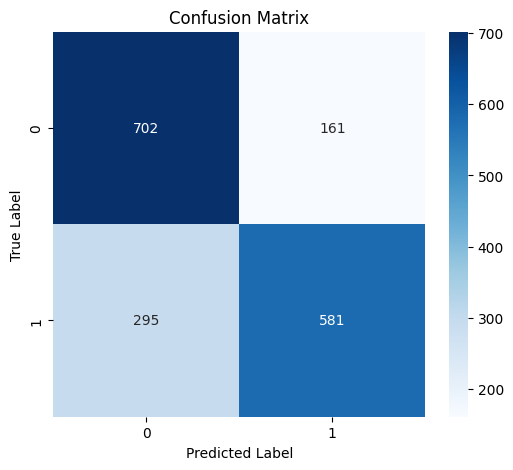

In [437]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score

md_boost = AdaBoostClassifier( n_estimators=100, random_state=42)
md_boost.fit(x_train, y_train)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
y_pred_boost = md_boost.predict(x_test)
boost_accuracy = cross_val_score(md_boost, x_test, y_test, cv=kf, scoring='accuracy')
cm = confusion_matrix(y_test, y_pred_boost)
print('Accuracy: ', boost_accuracy.mean())
print('Precision: ', precision_score(y_test, y_pred_boost))
print('Sensitivity: ', recall_score(y_test, y_pred_boost))
print('Specificity: ', recall_score(y_test, y_pred_boost, pos_label=0))
print('F1-Score: ', f1_score(y_test, y_pred_boost))
print('Matriz de confusion: \n')
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Comparacion de modelos


In [438]:
md = ['Regresion Logistica', 'LDA', 'Arbol de Decision', 'Random Forest', 'Boosting']
acc = [logReg_accuracy.mean(), lda_accuracy.mean(), tree_accuracy.mean(), rf_accuracy.mean(), boost_accuracy.mean()]
prec = [precision_score(y_test, y_pred_logReg), precision_score(y_test, y_pred_lda), precision_score(y_test, y_pred_tree), precision_score(y_test, y_pred_rf), precision_score(y_test, y_pred_boost)]
sens = [recall_score(y_test, y_pred_logReg), recall_score(y_test, y_pred_lda), recall_score(y_test, y_pred_tree), recall_score(y_test, y_pred_rf), recall_score(y_test, y_pred_boost)]
spec = [recall_score(y_test, y_pred_logReg, pos_label=0), recall_score(y_test, y_pred_lda, pos_label=0), recall_score(y_test, y_pred_tree, pos_label=0), recall_score(y_test, y_pred_rf, pos_label=0), recall_score(y_test, y_pred_boost, pos_label=0)]
f1_score = [f1_score(y_test, y_pred_logReg), f1_score(y_test, y_pred_lda), f1_score(y_test, y_pred_tree), f1_score(y_test, y_pred_rf), f1_score(y_test, y_pred_boost)]

comp_df = pd.DataFrame({'Modelo': md, 'Accuracy': acc, 'Precision': prec, 'Sensibilidad': sens, 'Especificidad': spec, 'F1-Score': f1_score})
comp_df = comp_df.set_index('Modelo')

comp_df

,Accuracy,Precision,Sensibilidad,Especificidad,F1-Score
Modelo,,,,,
Regresion Logistica,0.717652,0.774238,0.638128,0.811124,0.699625
LDA,0.723972,0.800298,0.613014,0.844728,0.694247
Arbol de Decision,0.675685,0.690992,0.691781,0.685979,0.691386
Random Forest,0.736064,0.816298,0.674658,0.845886,0.738750
Boosting,0.730874,0.783019,0.663242,0.813441,0.718171


Se puede observar que el modelo con mejor f1_score es el Random Forest, esto quiere decir que tiene un mejor promedio de proporciones entre sensibilidad y especificidad, este modelo cuenta con un accuracy de 0.73, que tambien es el mas alto de todos los modelos.

# Prueba Final con modelo de Random Forest

En esta prueba se utilizara la base de datos de test, que tambien fue previamente procesada.


In [439]:
df_test_processed_wo = df_test_processed.drop(['PassengerId'], axis = 1)

norm = StandardScaler()
df_test_processed = norm.fit_transform(df_test_processed_wo)

y_pred_test = md_rf.predict(df_test_processed_wo)
y_pred_test = y_pred_test.astype(bool)
results = pd.DataFrame({'PassengerId': df_test['PassengerId'], 'Transported': y_pred_test})
results.to_csv('results.csv', index=False)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [441]:
print('Numero de resultados True: ', results['Transported'].value_counts()[True])
print('Numero de resultados False: ', results['Transported'].value_counts()[False])

Numero de resultados True:  2611
Numero de resultados False:  1666
